<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-24_20_03_31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [16]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import MNIST as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
batch_size = 256
epochs = 10
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [19]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [20]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

In [21]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [22]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [23]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [24]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 25

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [25]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [26]:
model = Module().to(device)

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

Task 0 Start!
Epoch	1	Acc:  0.8198, Loss:  0.0029
Epoch	2	Acc:  0.8865, Loss:  0.0017
Epoch	3	Acc:  0.8957, Loss:  0.0015
Epoch	4	Acc:  0.9004, Loss:  0.0014
Epoch	5	Acc:  0.9043, Loss:  0.0014
Epoch	6	Acc:  0.9068, Loss:  0.0013
Epoch	7	Acc:  0.9090, Loss:  0.0013
Epoch	8	Acc:  0.9104, Loss:  0.0013
Epoch	9	Acc:  0.9122, Loss:  0.0012
Epoch	10	Acc:  0.9131, Loss:  0.0012
Task 0 Acc:  0.9186, Loss:  0.0012
Task 1 Acc:  0.1509, Loss:  0.0206

Task 1 Start!
Epoch	1	Acc:  0.4871, Loss:  0.0092
Epoch	2	Acc:  0.6116, Loss:  0.0071
Epoch	3	Acc:  0.6335, Loss:  0.0068
Epoch	4	Acc:  0.6452, Loss:  0.0066
Epoch	5	Acc:  0.6531, Loss:  0.0065
Epoch	6	Acc:  0.6596, Loss:  0.0065
Epoch	7	Acc:  0.6620, Loss:  0.0064
Epoch	8	Acc:  0.6647, Loss:  0.0064
Epoch	9	Acc:  0.6675, Loss:  0.0063
Epoch	10	Acc:  0.6691, Loss:  0.0063
Task 0 Acc:  0.7768, Loss:  0.0030
Task 1 Acc:  0.6751, Loss:  0.0043



 - Task 0

Accuracy 0.7768
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.82      0.86      0.84       980
     1 - one       0.97      0.70      0.82      1135
     2 - two       0.59      0.60      0.60      1032
   3 - three       0.81      0.82      0.82      1010
    4 - four       0.77      0.84      0.80       982
    5 - five       0.84      0.71      0.77       892
     6 - six       0.69      0.88      0.77       958
   7 - seven       0.95      0.77      0.85      1028
   8 - eight       0.66      0.79      0.71       974
    9 - nine       0.80      0.82      0.81      1009

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



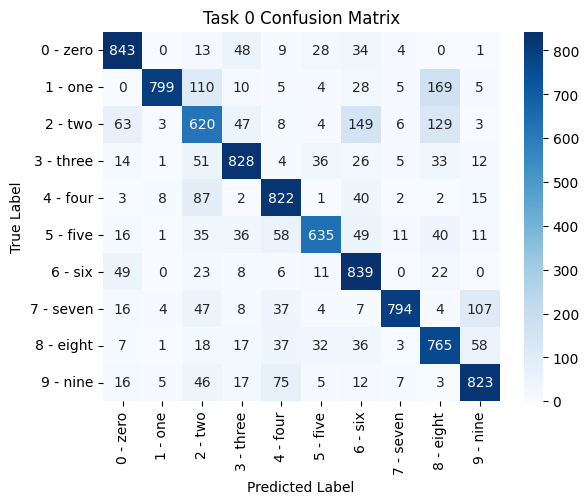

In [27]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.6751
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.87      0.94      0.90       980
     1 - one       0.90      0.91      0.90      1135
     2 - two       0.75      0.68      0.71      1032
   3 - three       0.57      0.62      0.59      1010
    4 - four       0.43      0.44      0.43       982
    5 - five       0.33      0.27      0.30       892
     6 - six       0.83      0.83      0.83       958
   7 - seven       0.74      0.77      0.75      1028
   8 - eight       0.57      0.54      0.55       974
    9 - nine       0.66      0.68      0.67      1009

    accuracy                           0.68     10000
   macro avg       0.66      0.67      0.66     10000
weighted avg       0.67      0.68      0.67     10000



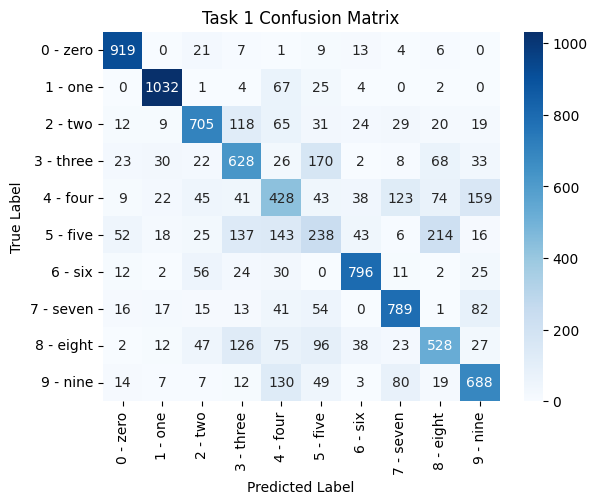

In [28]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.1.weight
torch.Size([10, 784])
Max fisher is 0.00612 and it's parameter diff is 0.01001
Min Parameter diff is 0.47226 and it's fisher is 0.00022
fisher > parameter diff: 52
fisher <= parameter diff: 732


<Figure size 640x480 with 0 Axes>

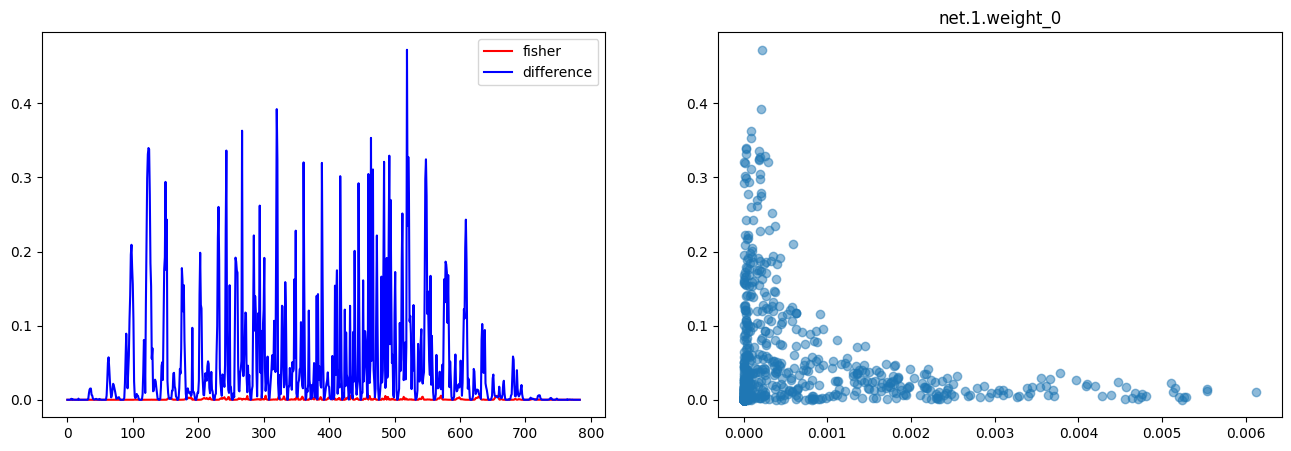

Max fisher is 0.00663 and it's parameter diff is 0.00418
Min Parameter diff is 1.24852 and it's fisher is 0.00018
fisher > parameter diff: 58
fisher <= parameter diff: 726


<Figure size 640x480 with 0 Axes>

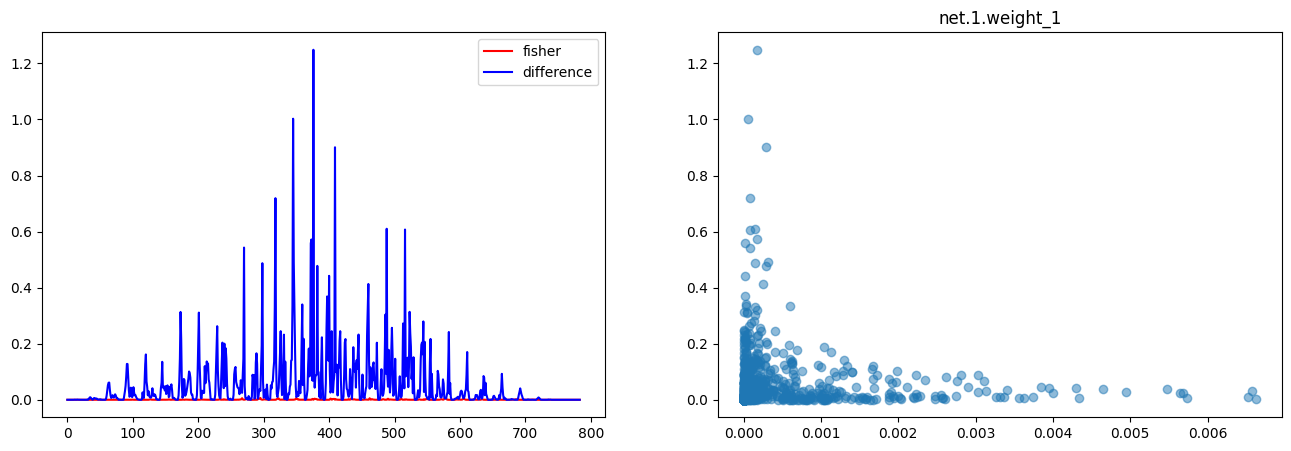

Max fisher is 0.00989 and it's parameter diff is 0.00492
Min Parameter diff is 0.74121 and it's fisher is 0.00011
fisher > parameter diff: 57
fisher <= parameter diff: 727


<Figure size 640x480 with 0 Axes>

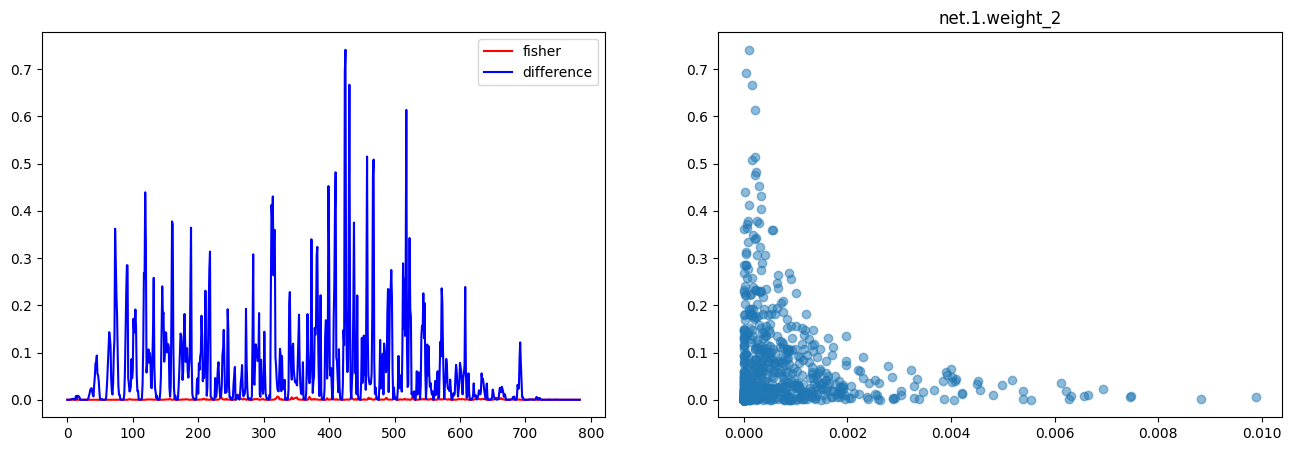

Max fisher is 0.09344 and it's parameter diff is 0.00040
Min Parameter diff is 0.90547 and it's fisher is 0.00012
fisher > parameter diff: 280
fisher <= parameter diff: 504


<Figure size 640x480 with 0 Axes>

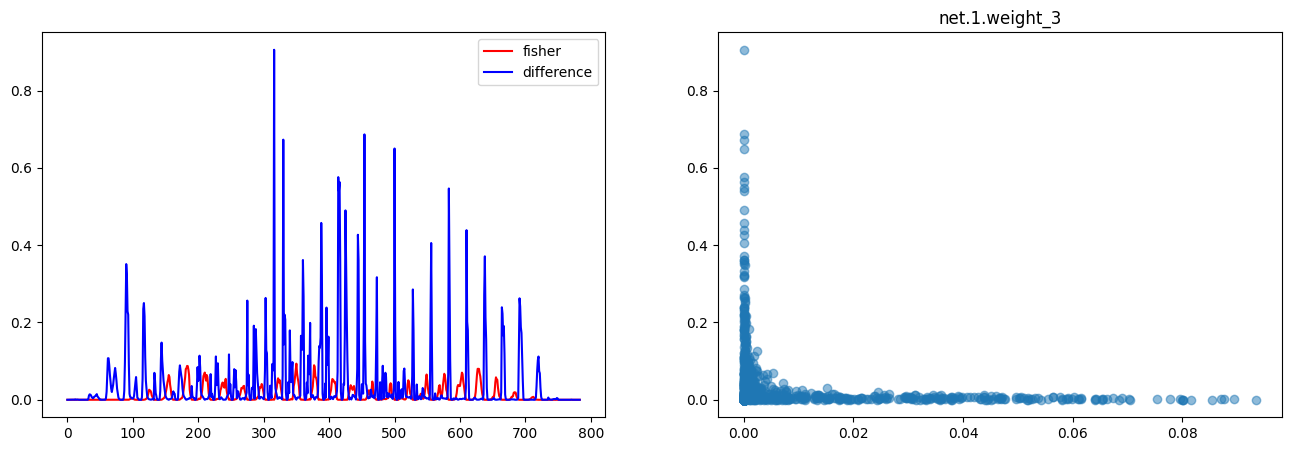

Max fisher is 0.09233 and it's parameter diff is 0.00300
Min Parameter diff is 0.86731 and it's fisher is 0.00011
fisher > parameter diff: 191
fisher <= parameter diff: 593


<Figure size 640x480 with 0 Axes>

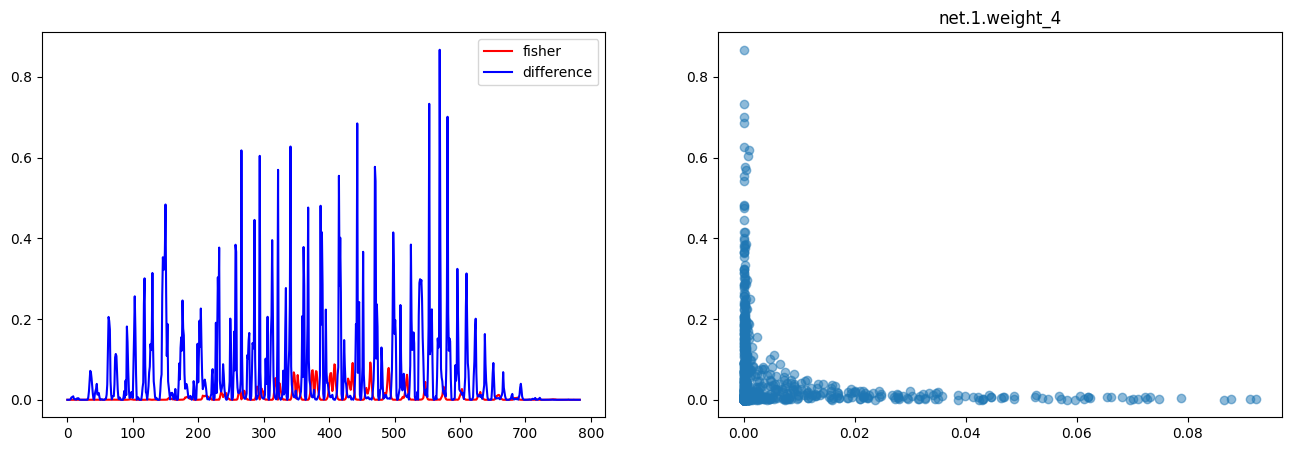

Max fisher is 0.11870 and it's parameter diff is 0.00354
Min Parameter diff is 1.52938 and it's fisher is 0.00002
fisher > parameter diff: 249
fisher <= parameter diff: 535


<Figure size 640x480 with 0 Axes>

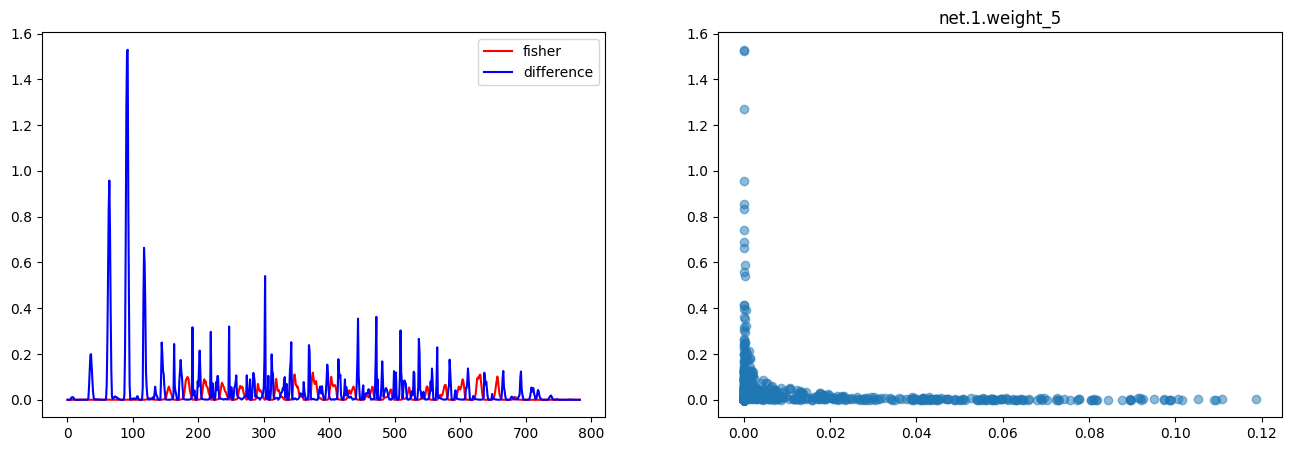

Max fisher is 0.00459 and it's parameter diff is 0.02483
Min Parameter diff is 0.77997 and it's fisher is 0.00016
fisher > parameter diff: 41
fisher <= parameter diff: 743


<Figure size 640x480 with 0 Axes>

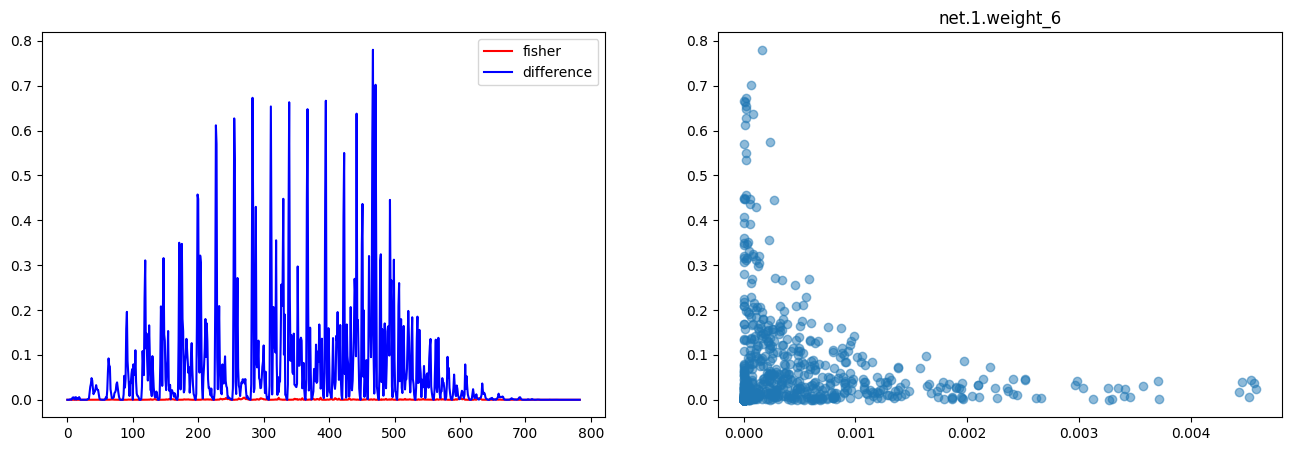

Max fisher is 0.02212 and it's parameter diff is 0.00238
Min Parameter diff is 0.65009 and it's fisher is 0.00000
fisher > parameter diff: 110
fisher <= parameter diff: 674


<Figure size 640x480 with 0 Axes>

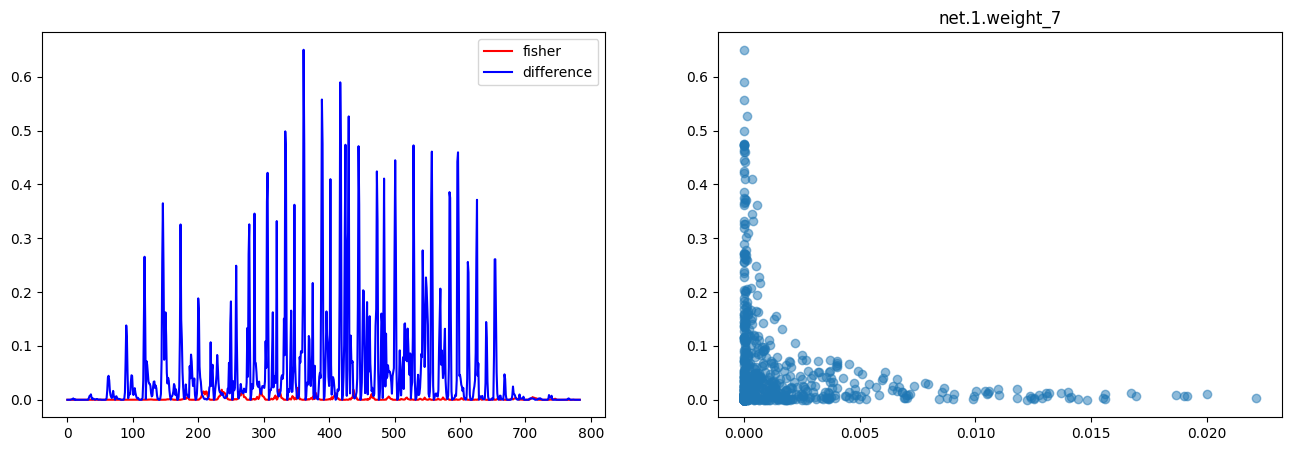

Max fisher is 0.05970 and it's parameter diff is 0.00019
Min Parameter diff is 0.65871 and it's fisher is 0.00002
fisher > parameter diff: 196
fisher <= parameter diff: 588


<Figure size 640x480 with 0 Axes>

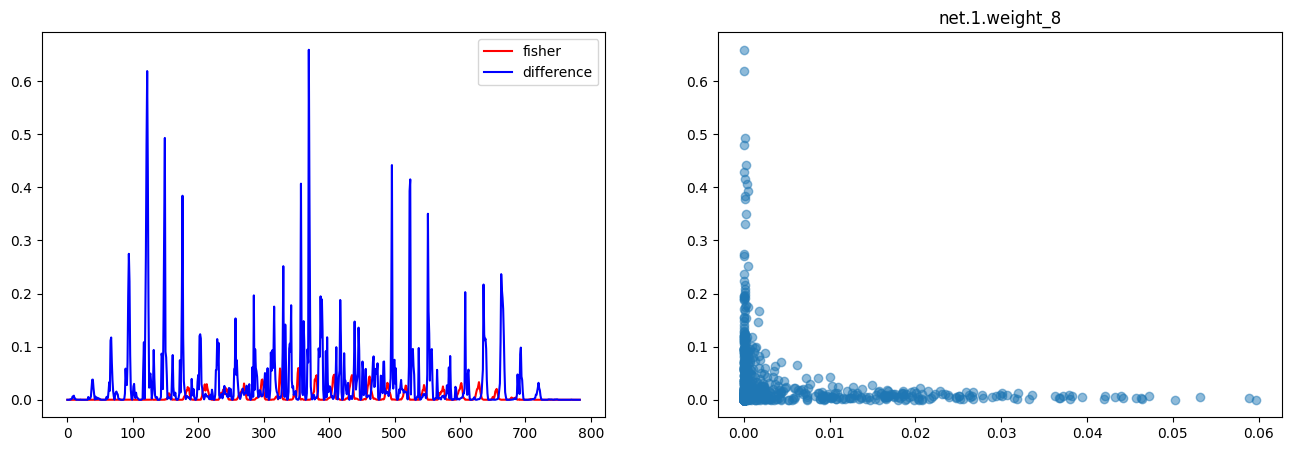

Max fisher is 0.02865 and it's parameter diff is 0.00252
Min Parameter diff is 0.62729 and it's fisher is 0.00014
fisher > parameter diff: 140
fisher <= parameter diff: 644


<Figure size 640x480 with 0 Axes>

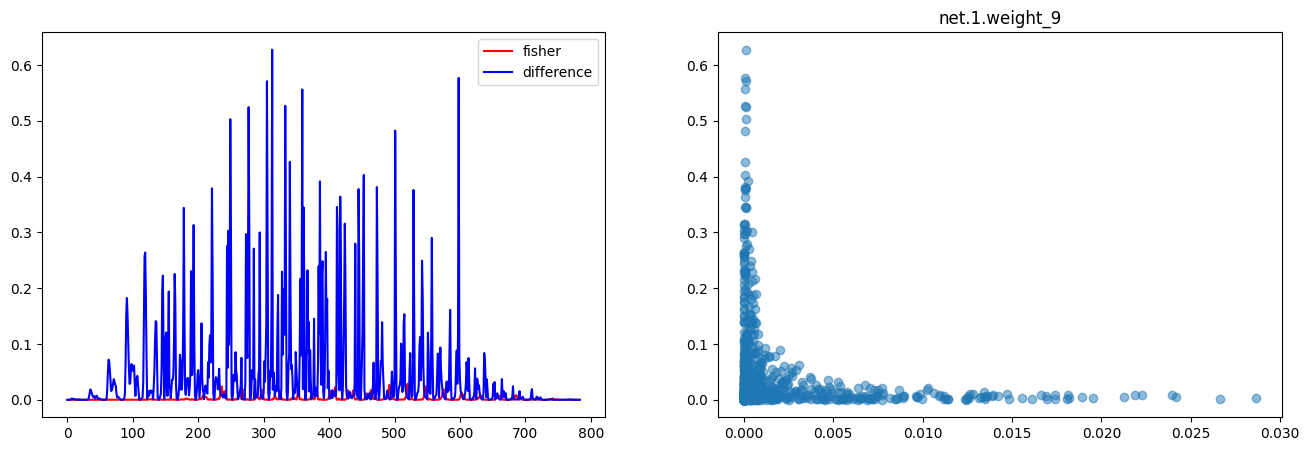


net.1.bias
torch.Size([10])
Max fisher is 0.36213 and it's parameter diff is 0.00099
Min Parameter diff is 0.03075 and it's fisher is 0.00196
fisher > parameter diff: 6
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

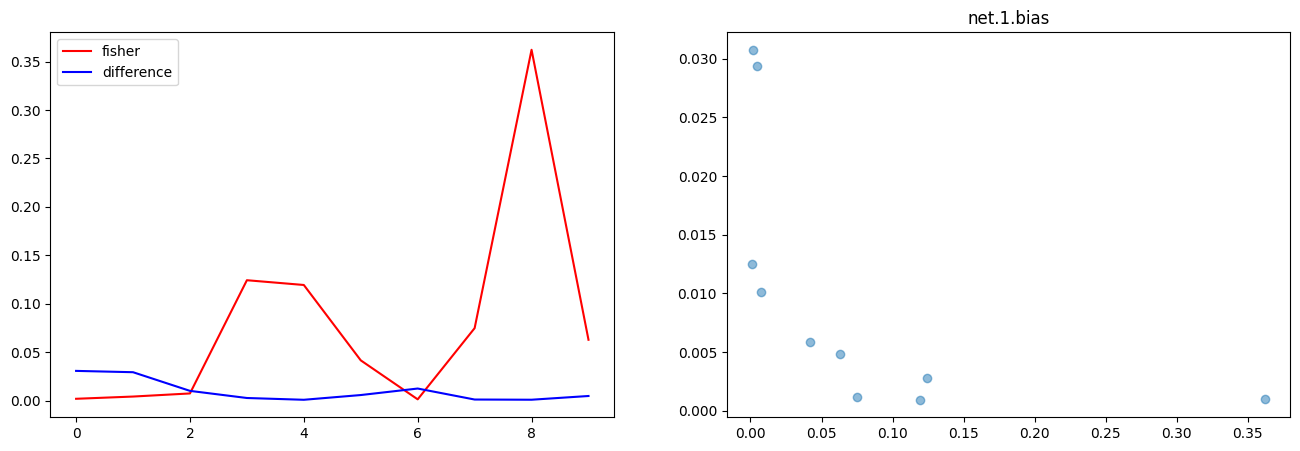

In [29]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')
  # compare
  print('fisher > parameter diff: {}'.format((fisher > (optim - param).abs()).sum()))
  print('fisher <= parameter diff: {}'.format((fisher <= (optim - param).abs()).sum()))

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i], optim_para[0][name][i], param[i], f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [30]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-24_20_03_31
